In [1]:

# 0. 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
train = pd.read_csv('train.csv', index_col=0) # 코랩 사용 시 경로(/content/drive/My Drive/Colab Notebooks/) 추가
test = pd.read_csv('test.csv', index_col=0)
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)

# 2. Train 데이터의 타입을 Sample_submission에 대응하는 가변수 형태로 변환
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x : to_number(x, column_number))

# 3.모델에 적용할 데이터 셋 준비 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer

train_x = train.drop(columns=['type', 'type_num'], axis=1)
del train_x['fiberID']
train_y = train['type_num']
test_x = test
del test_x['fiberID']

train_x.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


In [2]:
# 간단한 이상치 제거

# 0.985,0.015
x = train_x.copy() 

down_quantiles = x.quantile(0.002) # 전처리 비율 조정
up_quantiles = x.quantile(0.998)

outliers_low = (x < down_quantiles)
outliers_high = (x > up_quantiles)

x[outliers_low] = np.nan
x.fillna(down_quantiles, inplace=True)

x[outliers_high] = np.nan
x.fillna(up_quantiles, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdfe0bb0450>,
      dtype=object)

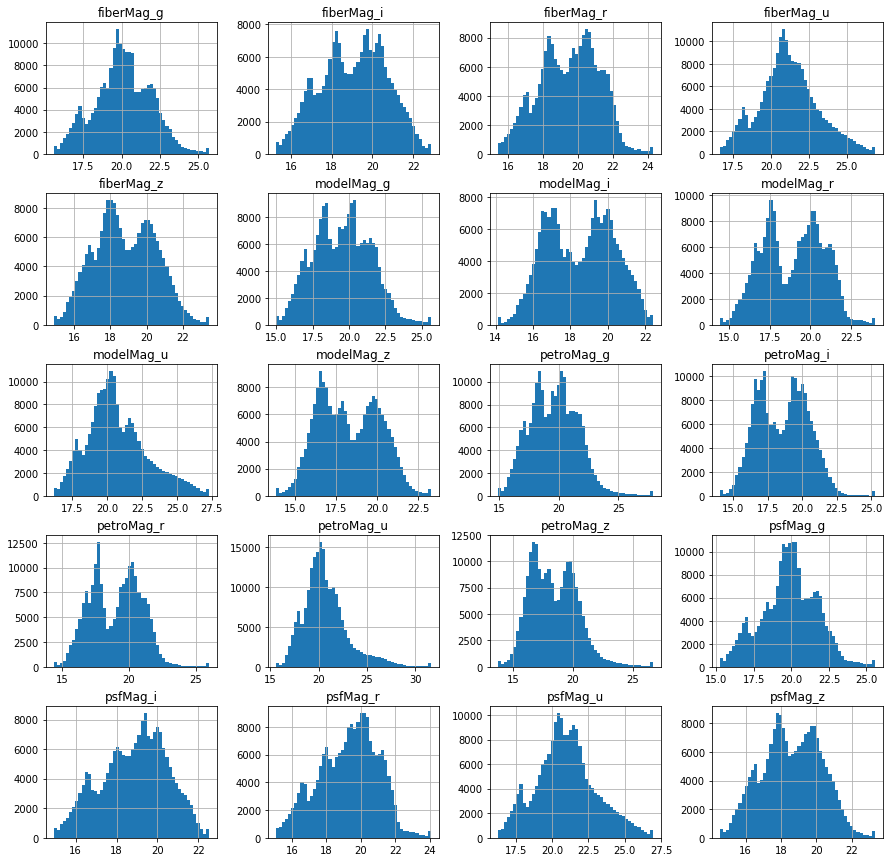

In [3]:
x.hist(bins=50, figsize=(15, 15))

In [13]:
x = x.values
train_y = train_y.values

x_train, x_val, y_train, y_val = train_test_split(x, train_y, train_size=0.9)

# 3-1 다중 분류 시 One-hot Encoding
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()
y_train = y_train.reshape(len(y_train), -1) 
y_val = y_val.reshape(len(y_val), -1)
y_train = onehot_encoder.fit_transform(y_train)
y_val = onehot_encoder.fit_transform(y_val)

print(x_train.shape)
print(y_train.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [14]:
print(y_train.shape)

(179991, 19)


In [12]:
# StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

# 4. 모델 생성하기
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU, Input
from keras import regularizers


input1 = Input(shape=(20,))
dense1 = Dense(128, kernel_regularizer=regularizers.l2(0.000003))(input1)
dense1 = BatchNormalization()(dense1)
dense1 = LeakyReLU(alpha=0.07)(dense1)
dense1 = Dense(256)(dense1) 
dense1 = BatchNormalization()(dense1)
dense1 = LeakyReLU(alpha=0.07)(dense1)
dense1 = Dropout(0.45)(dense1)
dense1 = Dense(256)(dense1)
dense1 = BatchNormalization()(dense1)
dense1 = LeakyReLU(alpha=0.07)(dense1)
dense1 = Dropout(0.45)(dense1)
dense1 = Dense(256)(dense1) 
dense1 = LeakyReLU(alpha=0.07)(dense1)
dense1 = Dropout(0.45)(dense1)
dense1 = Dense(256)(dense1)
dense1 = LeakyReLU(alpha=0.07)(dense1)
dense1 = Dropout(0.45)(dense1)
output1 = Dense(19, activation='softmax')(dense1)

model = Model(inputs=input1, outputs=output1)


# 5. 모델 훈련시키기 
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=800, mode='min')
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])
hist = model.fit(x_train_scaled,y_train, epochs=3000, batch_size=256, validation_data = [x_val_scaled, y_val], callbacks=[early_stopping])

# # 6. 평가 검증하기
loss, acc = model.evaluate(x_val_scaled, y_val)
print('loss :', loss)
print('acc :', acc)

# 7. 예측
test_x_scaled = scaler.transform(test_x)
y_pred = model.predict(test_x_scaled)


# 8. 제출 파일 생성
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission(14).csv', index=True)


# early stopping patience 200 이상일 경우 overfitting
# Dropout 0.3 이하 overfitting 발생
# hidden layer 4개 이하 overfitting 발생
# node = 512일 경우 overfitting 발생

# 가장 기록 좋았을 때
# model = Sequential()

# model.add(Dense(128, input_shape=(20,)))
# model.add(LeakyReLU(alpha=0.07))
# model.add(BatchNormalization())
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(BatchNormalization())
# model.add(Dropout(0.45))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(BatchNormalization())
# model.add(Dropout(0.45))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(Dropout(0.45))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(Dropout(0.45))
# model.add(Dense(19, activation='softmax'))

Train on 179991 samples, validate on 20000 samples
Epoch 1/3000
179991/179991 [==============================] - 8s 45us/step - loss: 0.7861 - acc: 0.7554 - val_loss: 0.5488 - val_acc: 0.8029
Epoch 2/3000
179991/179991 [==============================] - 7s 38us/step - loss: 0.5866 - acc: 0.8088 - val_loss: 0.4725 - val_acc: 0.8395
Epoch 3/3000
179991/179991 [==============================] - 7s 38us/step - loss: 0.5495 - acc: 0.8180 - val_loss: 0.4911 - val_acc: 0.8303
Epoch 4/3000
179991/179991 [==============================] - 7s 38us/step - loss: 0.5315 - acc: 0.8239 - val_loss: 0.4710 - val_acc: 0.8334
Epoch 5/3000
179991/179991 [==============================] - 7s 38us/step - loss: 0.5186 - acc: 0.8278 - val_loss: 0.4951 - val_acc: 0.8373
Epoch 6/3000
179991/179991 [==============================] - 7s 38us/step - loss: 0.5119 - acc: 0.8282 - val_loss: 0.4600 - val_acc: 0.8421
Epoch 7/3000
179991/179991 [==============================] - 7s 39us/step - loss: 0.5032 - acc: 0.8313

179991/179991 [==============================] - 7s 38us/step - loss: 0.4255 - acc: 0.8542 - val_loss: 0.3819 - val_acc: 0.8669
Epoch 116/3000
179991/179991 [==============================] - 7s 38us/step - loss: 0.4254 - acc: 0.8542 - val_loss: 0.3837 - val_acc: 0.8637
Epoch 117/3000
179991/179991 [==============================] - 7s 38us/step - loss: 0.4256 - acc: 0.8540 - val_loss: 0.3860 - val_acc: 0.8652
Epoch 118/3000
179991/179991 [==============================] - 7s 38us/step - loss: 0.4243 - acc: 0.8541 - val_loss: 0.3904 - val_acc: 0.8634
Epoch 119/3000
179991/179991 [==============================] - 7s 38us/step - loss: 0.4268 - acc: 0.8539 - val_loss: 0.3903 - val_acc: 0.8636
Epoch 120/3000
179991/179991 [==============================] - 7s 38us/step - loss: 0.4242 - acc: 0.8542 - val_loss: 0.3902 - val_acc: 0.8660
Epoch 121/3000
179991/179991 [==============================] - 7s 38us/step - loss: 0.4254 - acc: 0.8539 - val_loss: 0.3874 - val_acc: 0.8608
Epoch 122/3000

179991/179991 [==============================] - 5s 27us/step - loss: 0.4128 - acc: 0.8571 - val_loss: 0.3819 - val_acc: 0.8668
Epoch 230/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4142 - acc: 0.8572 - val_loss: 0.3792 - val_acc: 0.8698
Epoch 231/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4159 - acc: 0.8558 - val_loss: 0.3863 - val_acc: 0.8638
Epoch 232/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4145 - acc: 0.8571 - val_loss: 0.3829 - val_acc: 0.8673
Epoch 233/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4130 - acc: 0.8576 - val_loss: 0.3782 - val_acc: 0.8668
Epoch 234/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4128 - acc: 0.8578 - val_loss: 0.3784 - val_acc: 0.8682
Epoch 235/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4147 - acc: 0.8567 - val_loss: 0.3951 - val_acc: 0.8630
Epoch 236/3000

179991/179991 [==============================] - 5s 27us/step - loss: 0.4090 - acc: 0.8589 - val_loss: 0.3765 - val_acc: 0.8684
Epoch 344/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4097 - acc: 0.8590 - val_loss: 0.3808 - val_acc: 0.8680
Epoch 345/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4087 - acc: 0.8595 - val_loss: 0.3808 - val_acc: 0.8687
Epoch 346/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4099 - acc: 0.8580 - val_loss: 0.3788 - val_acc: 0.8674
Epoch 347/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4083 - acc: 0.8590 - val_loss: 0.3813 - val_acc: 0.8673
Epoch 348/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4077 - acc: 0.8598 - val_loss: 0.3849 - val_acc: 0.8674
Epoch 349/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4101 - acc: 0.8583 - val_loss: 0.3807 - val_acc: 0.8670
Epoch 350/3000

179991/179991 [==============================] - 5s 27us/step - loss: 0.4074 - acc: 0.8598 - val_loss: 0.3842 - val_acc: 0.8666
Epoch 458/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4098 - acc: 0.8585 - val_loss: 0.3785 - val_acc: 0.8701
Epoch 459/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4056 - acc: 0.8594 - val_loss: 0.3810 - val_acc: 0.8697
Epoch 460/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4037 - acc: 0.8609 - val_loss: 0.3727 - val_acc: 0.8705
Epoch 461/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4052 - acc: 0.8606 - val_loss: 0.3879 - val_acc: 0.8656
Epoch 462/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4063 - acc: 0.8597 - val_loss: 0.3769 - val_acc: 0.8698
Epoch 463/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4053 - acc: 0.8593 - val_loss: 0.3888 - val_acc: 0.8625
Epoch 464/3000

179991/179991 [==============================] - 5s 27us/step - loss: 0.4060 - acc: 0.8596 - val_loss: 0.3763 - val_acc: 0.8688
Epoch 572/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4044 - acc: 0.8610 - val_loss: 0.3865 - val_acc: 0.8659
Epoch 573/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4041 - acc: 0.8609 - val_loss: 0.3720 - val_acc: 0.8709
Epoch 574/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4035 - acc: 0.8610 - val_loss: 0.3743 - val_acc: 0.8697
Epoch 575/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4037 - acc: 0.8598 - val_loss: 0.3812 - val_acc: 0.8671
Epoch 576/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4034 - acc: 0.8613 - val_loss: 0.3952 - val_acc: 0.8637
Epoch 577/3000
179991/179991 [==============================] - 5s 27us/step - loss: 0.4040 - acc: 0.8606 - val_loss: 0.3770 - val_acc: 0.8697
Epoch 578/3000

KeyboardInterrupt: 

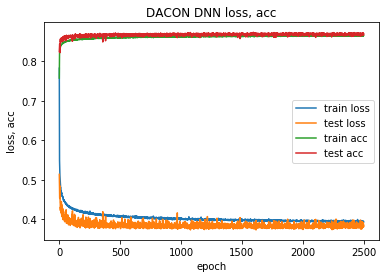

In [18]:
# matplotlib으로 보기
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('DACON DNN loss, acc')
plt.xlabel('epoch')
plt.ylabel('loss, acc')
plt.legend(['train loss', 'test loss', 'train acc', 'test acc'])
plt.show()

# First
# loss : 0.3751423681736819
# acc : 0.8720957365285246

# Second
# loss : 0.37057404349997003
# acc : 0.8689456582069397

# Third
# loss : 0.36412223417814554
# acc : 0.8720468282699585

# Fourth
# loss: 0.3597

# Fifth
# loss: 

# 최소 0.35~0.33까지 떨어뜨려야 함
# 참고 epoch 30% = earlystopping